## Preprocess Labels across Dataset

In [381]:
import os
import pickle as pkl
import sys ; sys.path.append('..')


from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


import EDGAR

    
# List of companies to process
tikrs = open(os.path.join('..', 'tickers.txt')).read().strip()
tikrs = [i.split(',')[0].lower() for i in tikrs.split('\n')]

label_dict_dir= os.path.join('..', 'data', 'cached')
label_dict_filename = 'label_summary_dict.pkl'

label_dict, total_docs = None, None
label_dict_path = os.path.join(label_dict_dir, label_dict_filename)

force = False

if not os.path.exists(label_dict_path) and not force:
    with open(label_dict_path, 'rb') as f:
        label_dict, total_docs = pkl.load(f)
else:
    data_dir = os.path.join('..', 'data')
    
    total_docs = 0

    metadata = EDGAR.metadata(data_dir=data_dir)
    loader = EDGAR.downloader(data_dir=data_dir);
    parser = EDGAR.parser(data_dir=data_dir, metadata=metadata)

    labels = dict()
    for tikr in tikrs:
        metadata.load_tikr_metadata(tikr)
        annotated_docs = parser.get_annotated_submissions(tikr)
    
        for doc in tqdm(annotated_docs, desc=f"Processing {tikr}", leave=False):
            total_docs += 1
            fname = metadata.get_10q_name(tikr, doc)

            # Try load cached, otherwise regenerate new file
            features = parser.featurize_file(tikr, doc, fname) 
        
            found_indices = np.unique([int(i) for i in features['found_index']])
            # Structure: Text str, Labels dict, labelled bool
            data = {i:{'text':None, 'labels':dict()} for i in found_indices}
            
            for i in range(len(features)):
                i = features.iloc[i, :]
                
                # Skip documents which are NOT annotated
                if not i['is_annotation']:
                    continue;

                d = data[i['found_index']]
                d['is_annotation'] = True
                
                if d['text'] is None:
                    d['text'] = i['value']
                
                d['labels'][i['annotation_index']] = i['name']
            
            # Add all labelled documents to trainset
            for i in data:
                #Only add labelled documents to trainset
                if not data[i].get('is_annotation', False):
                    continue; 
                d = data[i]
                
                for label in d['labels'].values():
                    if label not in labels:
                        labels[label] = {'tikr':dict(), 'total':dict(), 
                                         'document':dict(), 'document_by_tikr':dict()}
                        
                    labels[label]['tikr'][tikr] = labels[label]['tikr'].get(tikr, 0) + 1
                    labels[label]['document'][fname] = labels[label]['document'].get(fname, 0) + 1
                    
                    if tikr not in labels[label]['document_by_tikr']:
                        labels[label]['document_by_tikr'][tikr] = dict()
                        
                    labels[label]['document_by_tikr'][tikr][fname] = labels[label]['document_by_tikr'][tikr].get(fname, 0) + 1

    label_dict = labels
    if not os.path.exists(label_dict_dir):
        os.system(f'mkdir -p {label_dict_dir}')
    with open(label_dict_path, 'wb') as f:
        pkl.dump((label_dict, total_docs), f)

/home/seresne/ml/capstone/FinDocNLP/examples/../EDGAR/parser.py:161: RuntimeWarning: Document Encountered without 10-Q                                                      
  warnings.warn("Document Encountered without 10-Q", RuntimeWarning)
/home/seresne/ml/capstone/FinDocNLP/examples/../EDGAR/parser.py:168: RuntimeWarning: No Files under Document
  warnings.warn("No Files under Document", RuntimeWarning)


In [351]:
num_tikrs = len(tikrs) 
labels_all = list(label_dict.keys())
print(len(labels))
print(num_tikrs)

blue = "#1f77b4"
orange = "#ff7f0e"
green = "#2ca02c"

fig_dir = os.path.join('..','outputs','figs')
if not os.path.exists(fig_dir):
    os.system(f"mkdir -p {fig_dir}")

1655
10


In [174]:
stems = list(np.unique([i.split(':')[0] for i in labels]))
non_tikr_stems = list(set(stems) - set(tikrs))

assert len(non_tikr_stems) + num_tikrs == len(stems), 'Stems missing'
print(set(non_tikr_stems))
print(set(tikrs))

{'invest', 'us-gaap', 'us-gaap-supplement', 'srt', 'dei'}
{'gs', 'dis', 'ups', 'k', 'tdy', 'etsy', 'nflx', 'vz', 'pfe', 'atvi'}


In [398]:
labels_by_stem = dict()
for i in label_dict.keys():
    _stem = i.split(':')[0]
    labels_by_stem[_stem] = labels_by_stem.get(_stem, 0) + sum(list(label_dict[i]['tikr'].values()))
x = list(labels_by_stem.keys())
y = list(labels_by_stem.values())
print(labels_by_stem)

{'dei': 2768, 'us-gaap': 94434, 'nflx': 840, 'gs': 1626, 'srt': 5, 'tdy': 487, 'invest': 145, 'etsy': 503, 'atvi': 3799, 'k': 365, 'dis': 1147, 'pfe': 2210, 'ups': 1147, 'us-gaap-supplement': 2, 'vz': 935}


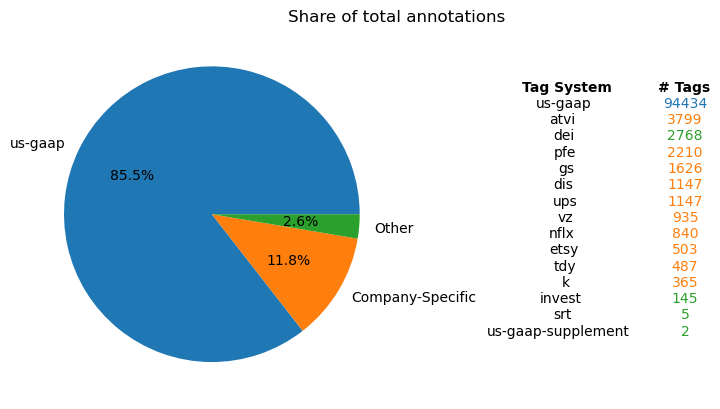

<Figure size 640x480 with 0 Axes>

In [411]:
counts_by_stem = {i:labels_by_stem[i] for i in non_tikr_stems}
company_tag = 'Company-Specific'
for _tikr in tikrs:
    counts_by_stem[company_tag] = counts_by_stem.get(company_tag, 0) + labels_by_stem.get(_tikr, 0)

other = ['us-gaap-supplement', 'invest', 'dei', 'srt']
for tag in other:
    counts_by_stem['Other'] = counts_by_stem.get('Other', 0) + counts_by_stem.pop(tag)
x = list(counts_by_stem.keys())
y = list(counts_by_stem.values())
plt.pie(y, labels=x, autopct='%1.1f%%')

def center_text(x0, text):
    offset = 0.03
    return x0-offset*len(text)

n_stems = len(stems)
offset = 0.11
for idx, _stem in enumerate(sorted(stems, key=lambda x: labels_by_stem[x], reverse=True)):
    
    height = offset*n_stems
    top = height/2 - 0.1
    text = f"{_stem}"; plt.text(center_text(2.4, text),top-height*idx/n_stems, text)
    color = blue
    if _stem in other:
        color = green
    elif _stem in tikrs:
        color = orange
    text = f"{labels_by_stem[_stem]}"; plt.text(center_text(3.2, text),top-height*idx/n_stems, text, color=color)

text = 'Tag System'; plt.text(center_text(2.4, text), offset*(n_stems+2)/2 - 0.1, text, fontweight='bold')
text = '# Tags'; plt.text(center_text(3.2, text), offset*(n_stems+2)/2 - 0.1, text, fontweight='bold')
title = plt.title(f"Share of total annotations")
title.set_x(1)

bbox = mpl.transforms.Bbox.from_bounds(1, 0.7, 8, 3.9)

plt.savefig(os.path.join(fig_dir, "share_anno_tags_pie.png"), bbox_inches=bbox, dpi=2000); plt.show(); plt.clf();

In [407]:
labels = [i for i in labels_all if i.split(':')[0] in non_tikr_stems]
labels_by_coverage = []
for _count in range(num_tikrs):
    labels_by_coverage.append([i for i in labels if len(list(label_dict[i]['tikr'].values())) == (_count+1)])

counts = np.array([len(i) for i in reversed(labels_by_coverage)])
total = sum(counts)

cumsum = np.cumsum(counts)/total

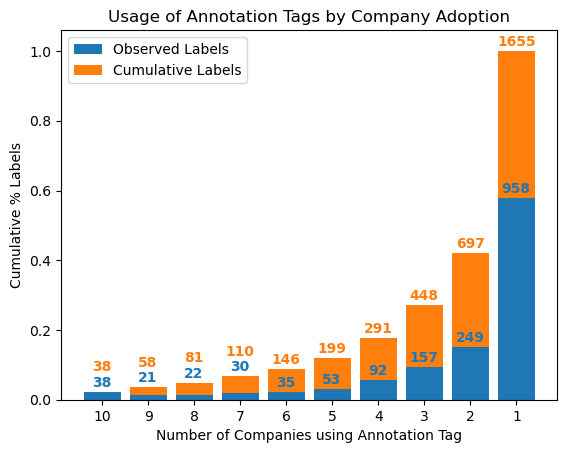

<Figure size 640x480 with 0 Axes>

In [410]:
x = np.arange(1,10+1)
plt.bar(x, counts/total, color=blue, label='Observed Labels')
plt.bar(x, cumsum-(counts/total), bottom=counts/total, color=orange, label='Cumulative Labels')
for x1 in x:
    count = str(counts[x1-1])
    x2 = x1-0.05-0.09*len(count)
    blue_y = counts[x1-1]/total + 0.015
    top_orange_y = cumsum[x1-1] + 0.015
    bot_orange_y = counts[x1-1]/total
    if blue_y + 0.06 > top_orange_y:
        blue_y = top_orange_y
    plt.text(x2, blue_y , count , color=blue, fontweight='bold')
    count = str(int(cumsum[x1-1]*total))
    x2 = x1-0.05-0.09*len(count)
    plt.text(x2, max(blue_y + 0.045, top_orange_y), 
             count , color=orange, fontweight='bold')
plt.legend(loc='upper left')
plt.xticks(x, (list(reversed(list(x)))))
plt.ylim(0,1.06)
plt.title('Usage of Annotation Tags by Company Adoption')
plt.ylabel('Cumulative % Labels')
plt.xlabel("Number of Companies using Annotation Tag")

plt.savefig(os.path.join(fig_dir, "anno_coverage_vs_company_adoption.png"), dpi=1200); plt.show(); plt.clf();

In [251]:
labels = [i for i in labels_all if i.split(':')[0] in non_tikr_stems]
labels_by_coverage = []

unique_docs = set()
for i in labels:
    unique_docs = unique_docs.union(set(label_dict[i]['document'].keys()))
num_docs = len(unique_docs)

for _count in range(num_docs):
    labels_by_coverage.append([i for i in labels if len(list(label_dict[i]['document'].values())) == (_count+1)])

labels_by_coverage = labels_by_coverage[::-1]
counts = np.array([len(i) for i in labels_by_coverage])

total = sum(counts)

cumsum = np.cumsum(counts)/total

In [252]:
a = set()
for idx, i in enumerate(labels_by_coverage):
    if labels[0] in set(i):
        print(idx)
        break

1


In [253]:
unique_docs = set()
for i in labels:
    unique_docs = unique_docs.union(set(label_dict[i]['document'].keys()))
print(len(unique_docs))

106


Text(0, 0.5, 'Cumulative Coverage')

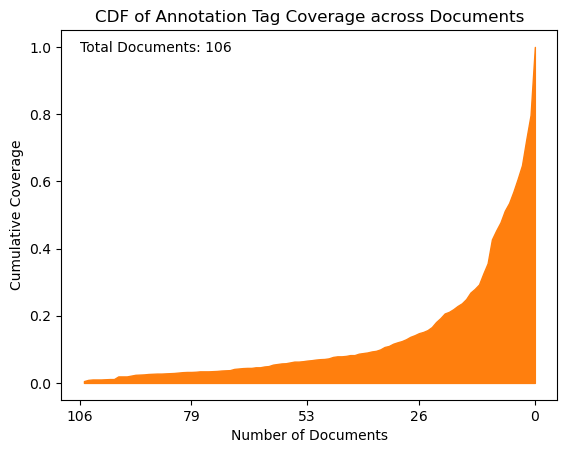

In [286]:
x = np.arange(1, num_docs+1)
plt.fill_between(x, cumsum, 0, color=orange)
plt.title('CDF of Annotation Tag Coverage across Documents')
n_ticks = 5
x = [int(i) for i in np.linspace(0, num_nonzero_counts, n_ticks)]
plt.xticks(x, x[::-1])
plt.text(x[0], 0.985, f'Total Documents: {num_docs}')
plt.xlabel("Number of Documents")
plt.ylabel("Cumulative Coverage")

In [180]:
counts

array([  9,   6,   2,   0,   0,   1,   1,   0,  13,   0,   0,   4,   4,
         1,   1,   2,   1,   1,   0,   1,   1,   1,   2,   2,   1,   0,
         1,   2,   0,   0,   1,   1,   2,   1,   1,   6,   2,   2,   1,
         0,   3,   0,   4,   2,   7,   3,   3,   1,   4,   4,   0,   2,
         3,   2,   3,   2,   1,   3,   7,   3,   0,   2,   4,   0,   7,
         3,   3,   5,   3,   7,  12,   5,  11,   7,   6,   9,  12,   8,
        10,   6,   9,  15,  25,  19,  23,   8,  13,  16,  13,  21,  32,
        18,  22,  54,  50, 118,  44,  40,  57,  38,  56,  63,  67, 127,
       120, 336])

In [197]:
for i in labels:
    a = label_dict[i]['document']
    if len(np.unique(a.values())) != 1:
        print(np.unique(a.values()))
        break

In [203]:
len(list(label_dict[labels[0]]['document'].values()))

105

In [209]:
counts

array([  9,   6,   2,   0,   0,   1,   1,   0,  13,   0,   0,   4,   4,
         1,   1,   2,   1,   1,   0,   1,   1,   1,   2,   2,   1,   0,
         1,   2,   0,   0,   1,   1,   2,   1,   1,   6,   2,   2,   1,
         0,   3,   0,   4,   2,   7,   3,   3,   1,   4,   4,   0,   2,
         3,   2,   3,   2,   1,   3,   7,   3,   0,   2,   4,   0,   7,
         3,   3,   5,   3,   7,  12,   5,  11,   7,   6,   9,  12,   8,
        10,   6,   9,  15,  25,  19,  23,   8,  13,  16,  13,  21,  32,
        18,  22,  54,  50, 118,  44,  40,  57,  38,  56,  63,  67, 127,
       120, 336])

In [214]:
a = np.array([np.array(i) for i in labels_by_coverage])

/tmp/ipykernel_78432/2591520918.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array([np.array(i) for i in labels_by_coverage])


In [215]:
labels[0] in a.flatten()

/tmp/ipykernel_78432/1411006766.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels[0] in a.flatten()


False

/tmp/ipykernel_78432/324929163.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels[0] in a


False